# Clemson version of image processing

## Dependencies

In [4]:
import sys
import random
import numpy as np
import pandas

from skimage.morphology import *
from skimage.util import invert
from skimage.filters import gaussian


from time import time
from scipy import ndimage, interpolate
from scipy.ndimage import median_filter


from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib import colorbar
get_ipython().magic('matplotlib inline')
import os
import glob
import re
import pickle
from PIL import Image
import pandas as pd
import cv2
from tifffile import imsave, imread, imwrite
from numba import jit
import yaml

from common.tiff_reader import read_tiff_volume
from ecoview_backend import oct_toolbox, measure_morphology

%load_ext autoreload


In [5]:
font = {'weight' : 'normal','size': 28}

matplotlib.rc('font', **font)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams['image.cmap'] = 'gray'

### Hyperparameters

In [6]:
# Data to be written to the YAML file
configs = {
        'mass_threshold': 0.10,
        'top_height': 100,
        'max_height': 300,
        'min_size': 50,
        'target_slices': 512,
        'target_cols': 512
    }
# Writing the data to a YAML file
with open('configs.yaml', 'w') as file:
    yaml.dump(configs, file)
    

# with open('configs.yaml', 'r') as file:
    # configs = yaml.safe_load(file)

### Plot estimation for the coupon surface and biofilm contours

In [5]:
file_list = [
    '/project/ahoover/mhealth/zeyut/biofilm/2024-12/Multi-days/12_9_24 Flow Cells_AYLFD86S_24_12_12_13_13_28.tif',
    '/project/ahoover/mhealth/zeyut/biofilm/2024-12/Multi-days/12_9_24 Flow Cells_KARFD73_24_12_10_23_15_07.tif',
    '/project/ahoover/mhealth/zeyut/biofilm/2024-12/Multi-days/12_9_24 Flow Cells_FCCFD91_24_12_14_19_58_29.tif',
    '/project/ahoover/mhealth/zeyut/biofilm/Gravity Flow 01_29_25/data/Gravity Flow 01_29_25 Continue imaging from 9am__BL_25_02_08_05_41_28.tif'
]


# file_path = '/project/ahoover/mhealth/zeyut/biofilm/2024-12/Shear/12_9_24 Flow Cells_KARFD83S_Final.tif'
# file_path = '/project/ahoover/mhealth/zeyut/biofilm/good_data_before_2024_12/data/multiwell pvc__BP-community-1__Day-13-3D-07-08-24.tif'
# file_path = '/project/ahoover/mhealth/zeyut/biofilm/Gravity Flow 01_29_25/data/Gravity Flow 01_29_25 Continue imaging from 9am__UR_25_01_29_18_11_23.tif'


In [6]:
%autoreload 1
%aimport ecoview_backend
base_lines = []
height_map = []
equalized = []
samples = []
for file_path in file_list:
    file_name = os.path.basename(file_path).split('.')[0]
    configs['file_path'] = file_path
    oct_ = ecoview_backend.oct_toolbox( **configs)
    oct_.binarize()
    oct_.remove_small_objects_3d()
    oct_.calc_cutoff_height_map()
    oct_.calc_base_map()
    samples.append(oct_.oct_stack[256])
    base_lines.append(oct_.base_map[256])
    height_map.append(oct_.calc_height_map())
    equalized.append(oct_.equalize_height_map())

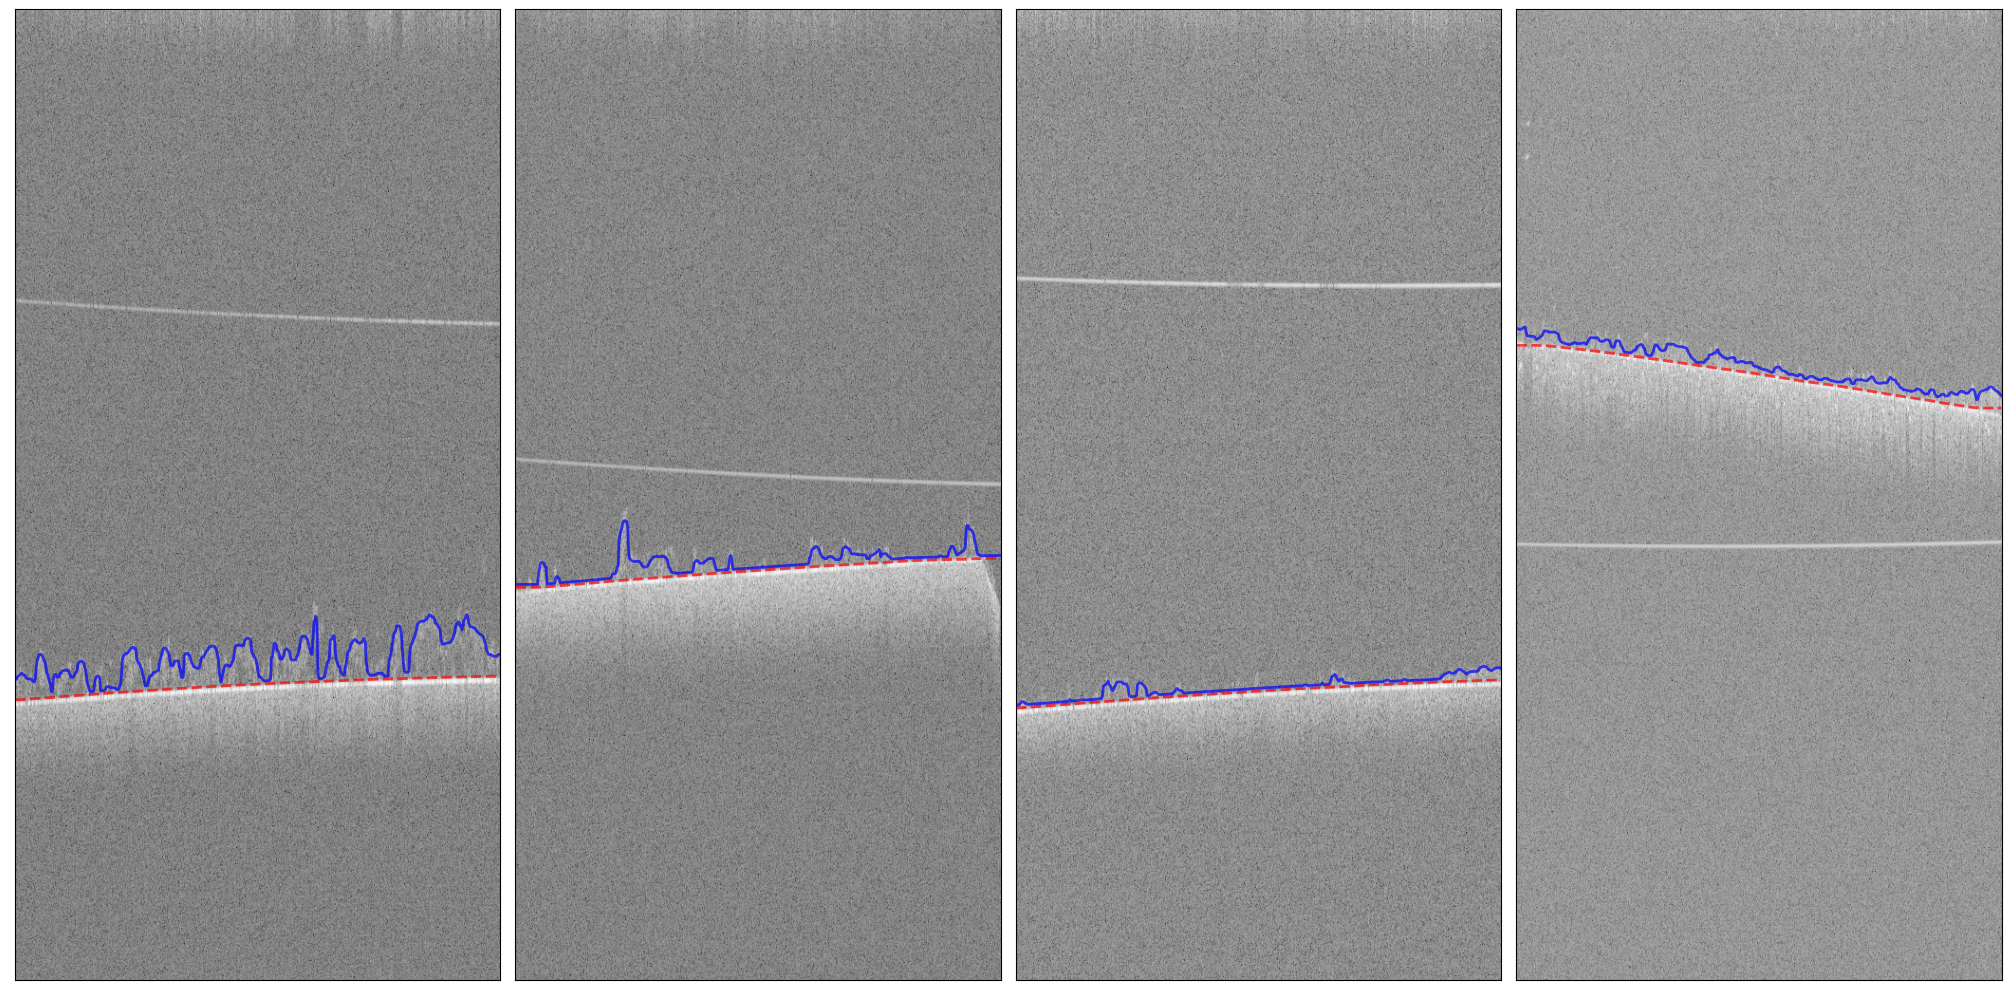

<Figure size 640x480 with 0 Axes>

In [13]:
fig, axs = plt.subplots(1, 4,
                        figsize=(20, 10),
                       constrained_layout=True)
for i in range(4):
    axs[i].imshow(samples[i])
    axs[i].plot(base_lines[i]+3, '--', c='r', linewidth=2, alpha=0.7)
    axs[i].plot(base_lines[i]-height_map[i][256], c='b', linewidth=2, alpha=0.7)
    axs[i].axes.get_xaxis().set_visible(False)
    axs[i].axes.get_yaxis().set_visible(False)
    
plt.show()
plt.tight_layout() 

In [14]:
fig.savefig('contours.jpg', dpi=300)

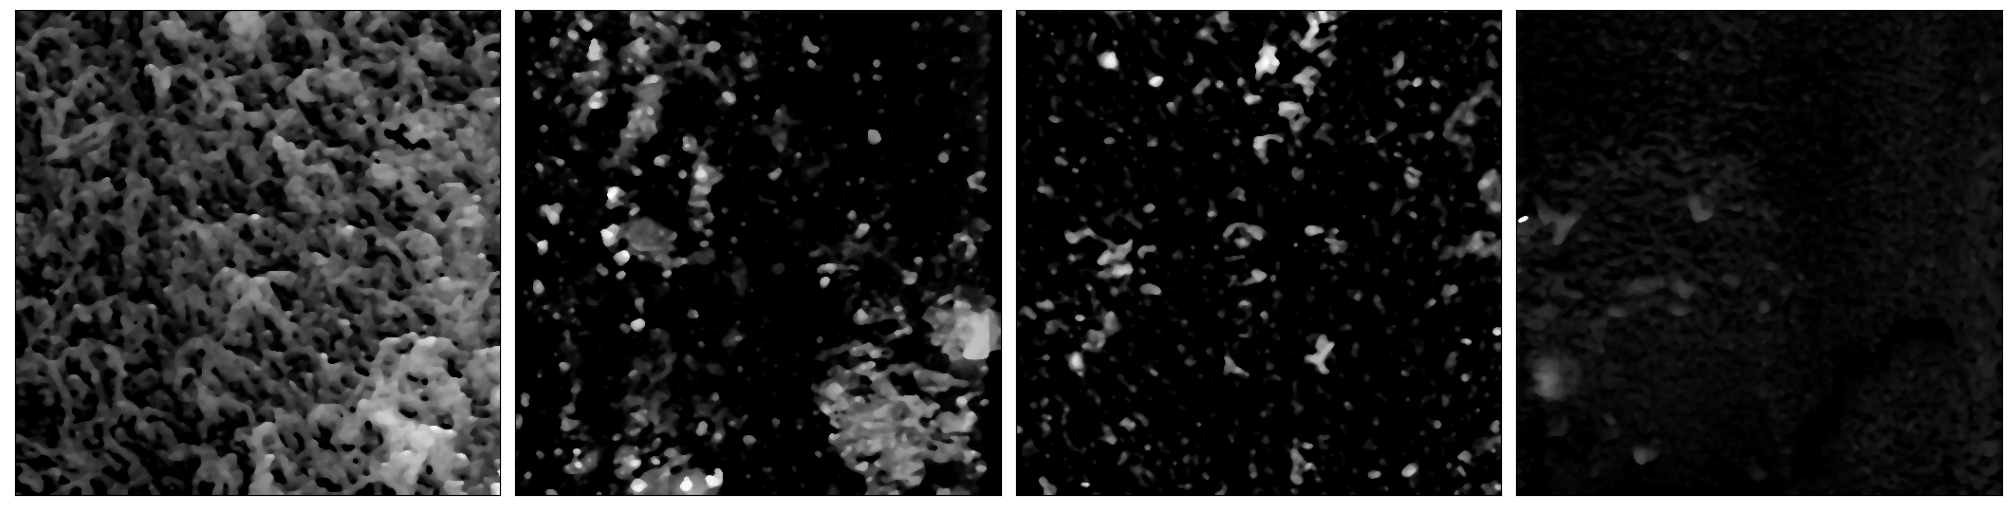

<Figure size 640x480 with 0 Axes>

In [17]:
fig, axs = plt.subplots(1, 4,
                        figsize=(20, 10),                       
                       constrained_layout=True)
for i in range(4):
    axs[i].imshow(height_map[i])
    axs[i].axes.get_xaxis().set_visible(False)
    axs[i].axes.get_yaxis().set_visible(False)
plt.show()
plt.tight_layout() 

In [18]:
fig.savefig('heights.jpg', dpi=300)

In [25]:
for i in range(4):
    results = measure_morphology(height_map[i])
    print('   '.join([f'{k}: {results[k]:.02f}' for k in ['Ra', 'Rq']]))

Ra: 0.58   Rq: 21.89
Ra: 1.36   Rq: 10.50
Ra: 1.57   Rq: 3.57
Ra: 0.70   Rq: 6.67


### Plot b-scan images with corrected coupon surface

In [15]:
file_list = [
    '/project/ahoover/mhealth/zeyut/biofilm/2024-12/Multi-days/12_9_24 Flow Cells_FCCFD91_24_12_13_17_00_40.tif',
    '/project/ahoover/mhealth/zeyut/biofilm/2024-12/Multi-days/12_9_24 Flow Cells_AYLFD86S_24_12_12_13_13_28.tif',
    '/project/ahoover/mhealth/zeyut/biofilm/2024-12/Multi-days/12_9_24 Flow Cells_AYLFD86_24_12_15_07_03_40.tif'
]

In [16]:
%autoreload 1
%aimport ecoview_backend
base_lines = []
height_map = []
equalized = []
samples = []
for file_path in file_list:
    file_name = os.path.basename(file_path).split('.')[0]
    configs['file_path'] = file_path
    oct_ = ecoview_backend.oct_toolbox( **configs)
    oct_.binarize()
    oct_.remove_small_objects_3d()
    oct_.calc_cutoff_height_map()
    oct_.calc_base_map()
    samples.append(oct_.oct_stack[256])
    base_lines.append(oct_.base_map[256])
    height_map.append(oct_.calc_height_map())
    equalized.append(oct_.equalize_height_map())

In [100]:
proc_bscans = []

for i in range(3):
    max_y = int(base_lines[i][0])+20
    min_y = int(base_lines[i][0]) - 180
    bscan = np.copy(samples[i])
    for col in range(len(bscan[0])):
        # print(int(base_lines[i][0]-base_lines[i][col]))
        bscan[:, col] = np.roll(bscan[:, col], int(base_lines[i][0]-base_lines[i][col]))
    img = bscan[min_y:max_y,:]
    # mask = img>np.percentile(img, 85, axis=0, keepdims=True)
    # img = np.where(mask, img, 0)
    # cv2.equalizeHist(img)
    proc_bscans.append(img)


In [101]:
cv2.imwrite('thin.jpg', proc_bscans[0])
cv2.imwrite('medium.jpg', proc_bscans[1])
cv2.imwrite('thick.jpg', proc_bscans[2])

True

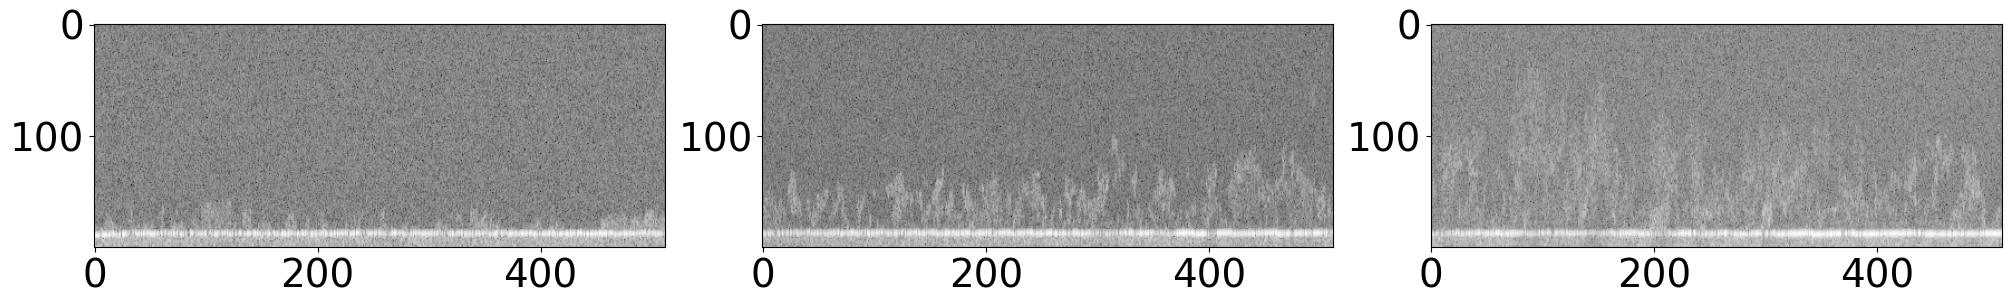

<Figure size 640x480 with 0 Axes>

In [102]:
fig, axs = plt.subplots(1, 3,
                        figsize=(20, 10),
                       constrained_layout=True)
for i in range(3):
    axs[i].imshow(proc_bscans[i])
    # axs[i].plot(base_lines[i]+3, '--', c='r', linewidth=2, alpha=0.7)
    # axs[i].axes.get_xaxis().set_visible(False)
    # axs[i].axes.get_yaxis().set_visible(False)
    
plt.show()
plt.tight_layout() 